https://the-juanjo.github.io/Base-de-Datos-de-Datos-de-Senales-PPG-para-Analisis-y-Estimacion-de-la-Presion-Arterial/


Número de muestras en el archivo: 12115



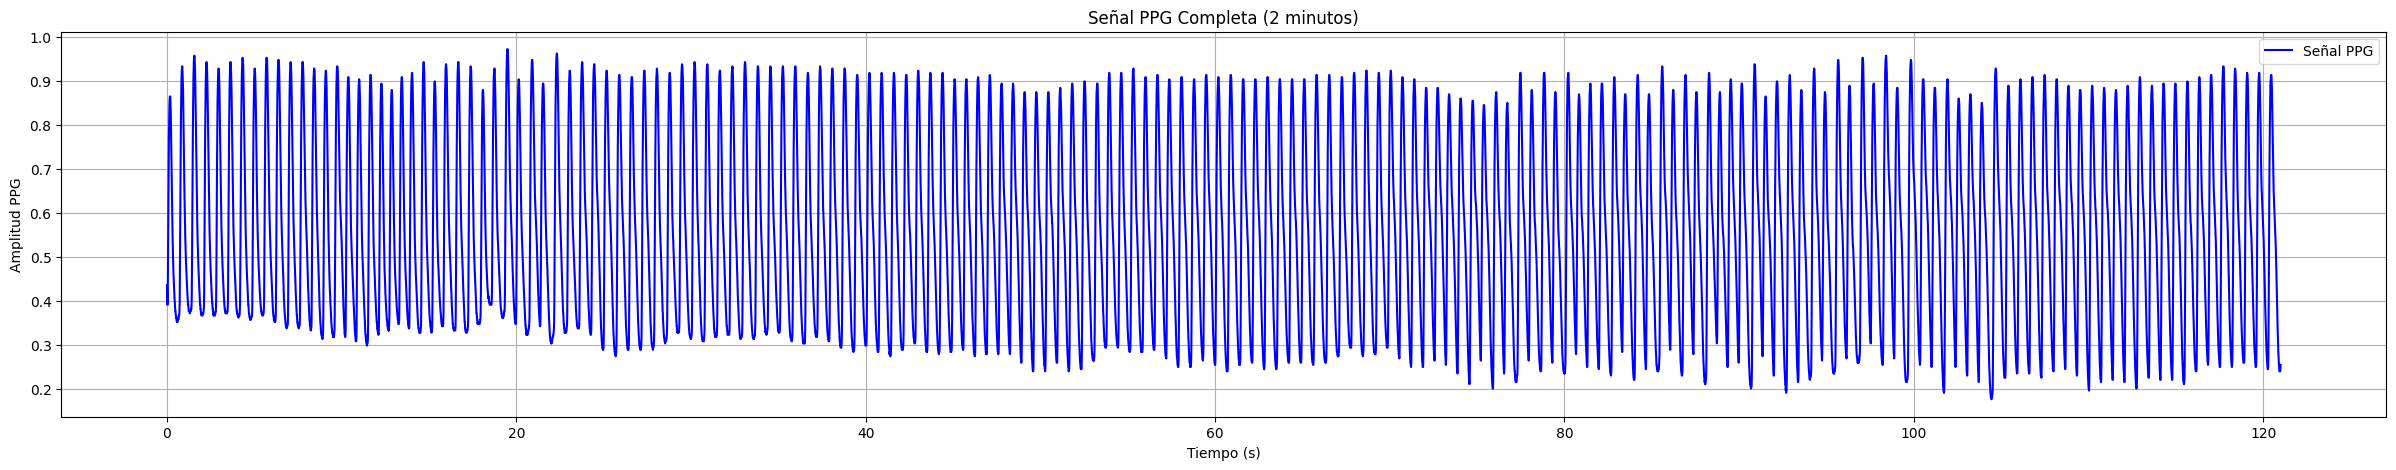

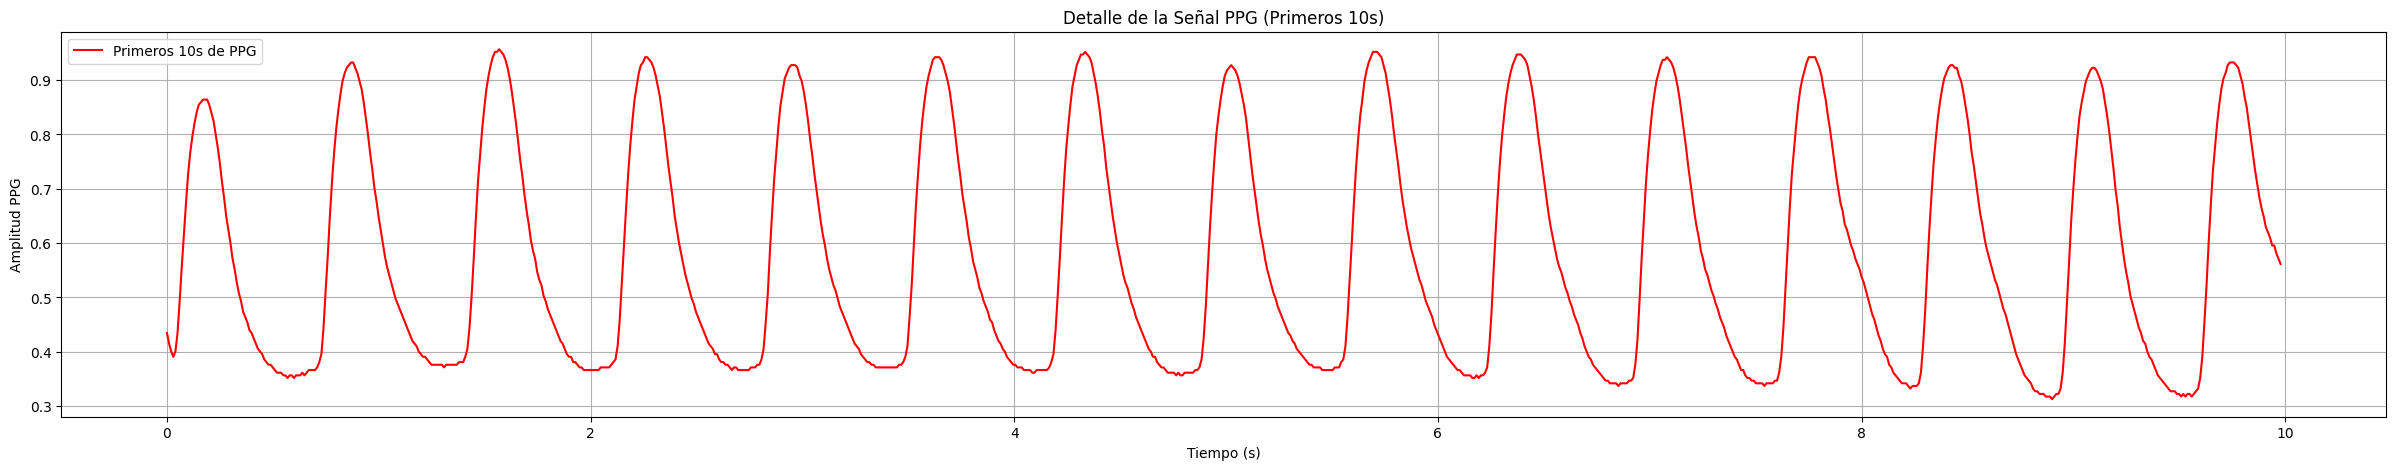

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Cargar el archivo CSV
file_path = "./BBDD/Colombia/Signal_PPG_Subj_5.csv"
ppg_data = pd.read_csv(file_path, header=None)  # En los CSV no hay encabezados

# 🔹 Parámetros de la señal
fs = 100  # Frecuencia de muestreo (Hz)
duration = 121  # Duración total en segundos
num_samples = fs * duration  # Número total de muestras esperadas

# 🔹 Verificar dimensiones del archivo
print(f"\nNúmero de muestras en el archivo: {len(ppg_data)}\n")

# 🔹 Crear el eje de tiempo
time = np.linspace(0, duration, len(ppg_data))

# 🔹 Visualizar la señal PPG completa
plt.figure(figsize=(30, 5))
plt.plot(time, ppg_data, label="Señal PPG", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud PPG")
plt.title("Señal PPG Completa (2 minutos)")
plt.legend()
plt.grid()
plt.show()

# 🔹 Visualizar un segmento de 10 segundos para más detalle
segment_duration = 10  # Segundos
samples_segment = fs * segment_duration  # Número de muestras del segmento

plt.figure(figsize=(30, 5))
plt.plot(time[:samples_segment], ppg_data[:samples_segment], color="red", label=f"Primeros {segment_duration}s de PPG")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud PPG")
plt.title(f"Detalle de la Señal PPG (Primeros {segment_duration}s)")
plt.legend()
plt.grid()
plt.show()

# Creación del Dataset

In [2]:
import pandas as pd

# 🔹 Cargar el CSV asegurando que se lee correctamente
csv_file = "./BBDD/Colombia/Datos_Registros_PPG.csv"
df = pd.read_csv(csv_file, delimiter=";", skiprows=0, engine='python')

# 🔹 Eliminar columnas vacías o sin nombre
df = df.dropna(axis=1, how='all')  # 🔹 Elimina columnas completamente vacías
df = df.dropna(axis=0, how='all')  # 🔹 Elimina filas completamente vacías

# 🔹 Renombrar columnas para evitar errores si tienen espacios o caracteres extraños
df.columns = df.columns.str.strip().str.replace(" ", "_")

# 🔹 Verificar la estructura corregida
print("Dimensiones del DataFrame:", df.shape)
print("Columnas:", df.columns)
print("Primeras filas:", df.head())

# 🔹 Si hay errores en los valores de alguna columna, verificamos
print("Valores únicos en la columna Diagnosed:", df["DiagNOosed"].unique())

Dimensiones del DataFrame: (56, 10)
Columnas: Index(['Sujeto', 'Age', 'Gender', 'DiagNOosed', 'TreatmeNOt', 'JNC', 'AHA',
       'Systolic_BP', 'Diastolic_BP', 'Heart_Rate'],
      dtype='object')
Primeras filas:         Sujeto   Age    Gender DiagNOosed TreatmeNOt    JNC    AHA  \
0  PPG_subj_01  44.0  Maculino        YES         NO    Pre  Hiper   
1  PPG_subj_02  58.0  Maculino        YES        YES  Normo  Normo   
2  PPG_subj_03  57.0  Femenino        YES        YES    Pre    Pre   
3  PPG_subj_04  48.0  Femenino        YES        YES    Pre    Pre   
4  PPG_subj_05  46.0  Femenino        YES        YES  Normo  Normo   

   Systolic_BP  Diastolic_BP  Heart_Rate  
0        124.0          83.0        76.0  
1        115.0          75.0        84.0  
2        121.0          72.0        56.0  
3        125.0          75.0        73.0  
4         97.0          64.0        86.0  
Valores únicos en la columna Diagnosed: ['YES' 'NO']


In [3]:
import os

# 🔹 Función para convertir nombres de sujeto a nombres de archivo CSV
def convertir_nombre_archivo(sujeto):
    if pd.isna(sujeto):  # 🔹 Evita errores con valores NaN
        return None
    numero = sujeto.replace("PPG_subj_", "")  # 🔹 Quita el prefijo
    numero = str(int(numero))  # 🔹 Convierte "02" en "2"
    return f"Signal_PPG_Subj_{numero}.csv"  # 🔹 Formato final

# 🔹 Aplicar la función a la columna "Sujeto" para crear una nueva columna con los nombres de archivo
df["Archivo_Senal"] = df["Sujeto"].apply(convertir_nombre_archivo)

# 🔹 Verificamos si los nombres generados coinciden con los archivos disponibles en la carpeta
archivos_disponibles = os.listdir("./")  # Cambia esto por la ruta real
df["Existe"] = df["Archivo_Senal"].apply(lambda x: x in archivos_disponibles if x else False)

# 🔹 Verificar resultados
print(df[["Sujeto", "Archivo_Senal", "Existe"]].head())


        Sujeto          Archivo_Senal  Existe
0  PPG_subj_01  Signal_PPG_Subj_1.csv   False
1  PPG_subj_02  Signal_PPG_Subj_2.csv   False
2  PPG_subj_03  Signal_PPG_Subj_3.csv   False
3  PPG_subj_04  Signal_PPG_Subj_4.csv   False
4  PPG_subj_05  Signal_PPG_Subj_5.csv   False


In [4]:
import pandas as pd
import numpy as np
import os
import re  # Para limpiar valores incorrectos
from sklearn.preprocessing import StandardScaler

# 🔹 Ruta donde están los archivos CSV de las señales
ruta_senales = "./BBDD/Colombia/"

# 🔹 Inicializar listas para almacenar señales, etiquetas y metadatos
X = []
Y = []
metadata = []

# 🔹 Recorrer el DataFrame y cargar las señales PPG
for _, row in df.iterrows():
    file_name = row["Archivo_Senal"]  # Nombre del archivo de señal
    file_path = os.path.join(ruta_senales, file_name)  # Ruta completa del archivo
    
    # 🔹 Verificar si el archivo existe
    if not os.path.exists(file_path):
        print(f"⚠️ Advertencia: Archivo no encontrado {file_name}, se omitirá.")
        continue  # Omitir si no existe
    
    # 🔹 Cargar la señal desde el archivo CSV (sin encabezados)
    signal_df = pd.read_csv(file_path, header=None, dtype=str)  # Leer como string para evitar errores
    ppg_signal_raw = signal_df.iloc[:, 0].values  # Extraer la única columna

    # 🔹 Función para limpiar valores incorrectos
    def clean_value(value):
        # Intentamos limpiar números con formato incorrecto (ej. "101.074.218.750.000")
        value = re.sub(r"[^\d.-]", "", value)  # Quitar caracteres no numéricos excepto '.' y '-'
        try:
            return float(value)  # Convertir a float
        except ValueError:
            return np.nan  # Si no se puede convertir, marcar como NaN

    # 🔹 Aplicar limpieza a toda la señal
    ppg_signal = np.array([clean_value(x) for x in ppg_signal_raw])
    
    # 🔹 Eliminar valores NaN resultantes de errores de conversión
    ppg_signal = ppg_signal[~np.isnan(ppg_signal)]

    # 🔹 Tomar solo los primeros 40 segundos (100 Hz de muestreo)
    fs = 100  # Frecuencia de muestreo
    segundos = 40 ################################################################################################### Segundos a discernir del total de disponible (120 segundos) baja calidad 
    samples = int(segundos * fs)
    ppg_signal = ppg_signal[:samples]  # Recortar la señal
    
    # 🔹 Normalizar la señal (evitar dividir por cero)
    min_val, max_val = np.min(ppg_signal), np.max(ppg_signal)
    if max_val - min_val > 0:
        ppg_signal = (ppg_signal - min_val) / (max_val - min_val)
    
    # 🔹 Determinar la etiqueta (True si es "Normo", False si tiene patología)
    label = True if row["JNC"].strip().lower() == "normo" else False  # Cambia "JNC" si es necesario
    
    # 🔹 Extraer metadatos (BP sistólica, BP diastólica y HR)
    metadata_row = [
        row["Systolic_BP"],  # Presión arterial sistólica
        row["Diastolic_BP"],  # Presión arterial diastólica
        row["Heart_Rate"],  # Frecuencia cardíaca
    ]
    metadata.append(metadata_row)
    
    # 🔹 Agregar al dataset
    X.append(ppg_signal)
    Y.append(label)

# 🔹 Convertir listas a arrays numpy
X = np.array(X)
Y = np.array(Y)
metadata = np.array(metadata, dtype=float)

# 🔹 Normalizar los metadatos
scaler = StandardScaler()
metadata = scaler.fit_transform(metadata)

# 🔹 Verificar dimensiones y distribución de clases
print("✅ Shape de X:", X.shape)  # (num_samples, samples)
print("✅ Shape de Y:", Y.shape)  # (num_samples,)
print("✅ Shape de metadata:", metadata.shape)  # (num_samples, 3)
print("✅ Distribución de etiquetas:", np.unique(Y, return_counts=True))

⚠️ Advertencia: Archivo no encontrado Signal_PPG_Subj_1.csv, se omitirá.
⚠️ Advertencia: Archivo no encontrado Signal_PPG_Subj_32.csv, se omitirá.
⚠️ Advertencia: Archivo no encontrado Signal_PPG_Subj_36.csv, se omitirá.
✅ Shape de X: (53, 4000)
✅ Shape de Y: (53,)
✅ Shape de metadata: (53, 3)
✅ Distribución de etiquetas: (array([False,  True]), array([34, 19]))


## Comprobacion visual de todas las señales con los segundos escogidos del total de 120 seg

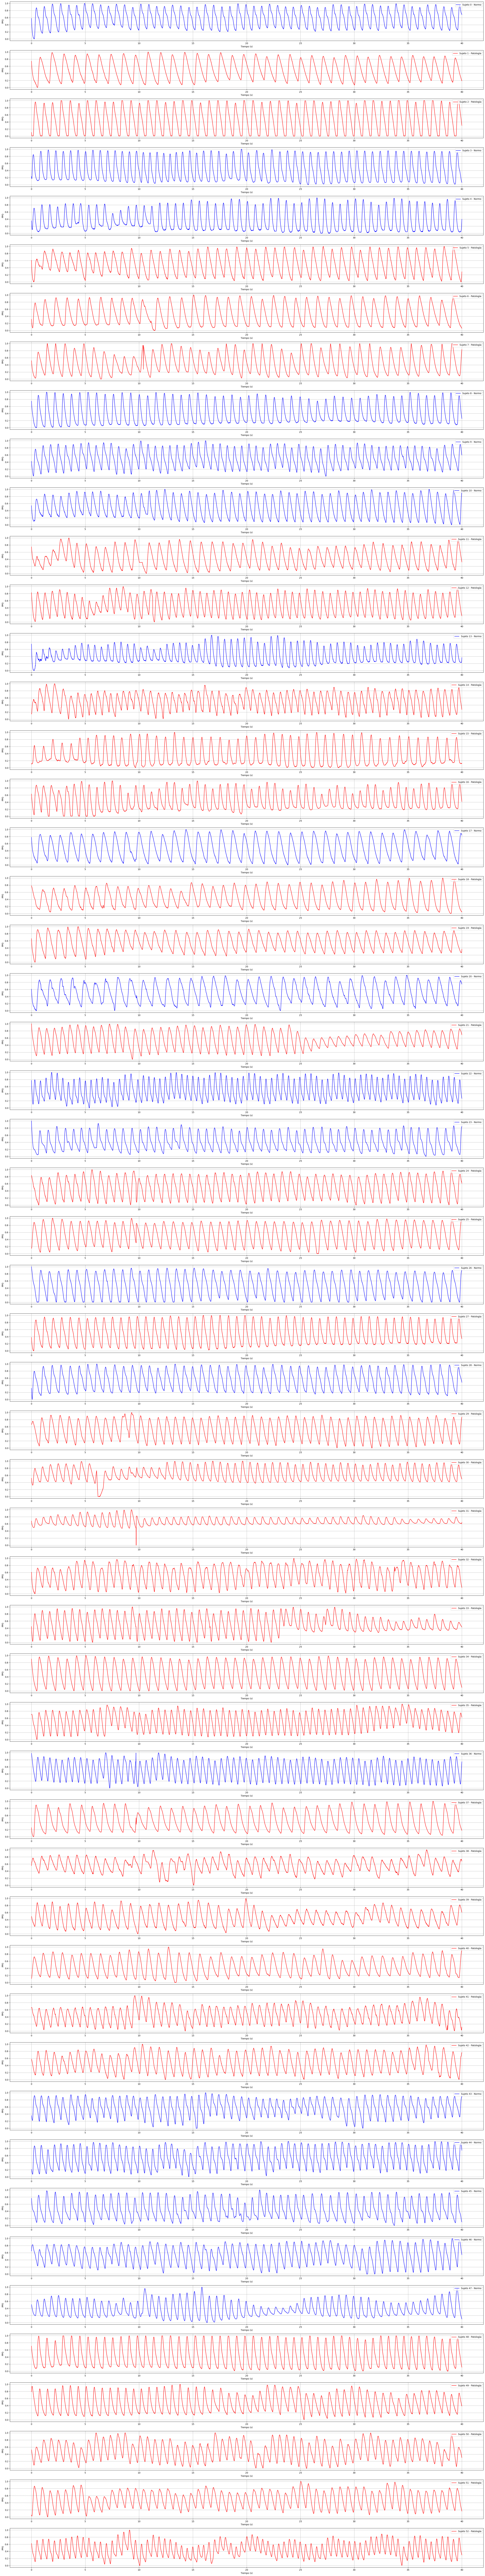

In [5]:
import matplotlib.pyplot as plt

# 🔹 Configuración de la figura
plt.figure(figsize=(30, len(X)*3))  # Aumentar el tamaño para mayor claridad
fs = 100  # Frecuencia de muestreo
time = np.linspace(0, segundos, segundos*100) 

# 🔹 Graficar todas las señales
for i in range(len(X)):
    plt.subplot(len(X), 1, i + 1)
    plt.plot(time, X[i], label=f"Sujeto {i} - {'Normo' if Y[i] else 'Patología'}", color="blue" if Y[i] else "red")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("PPG")
    plt.legend(loc="upper right")
    plt.grid()

# 🔹 Ajustar diseño y mostrar
plt.tight_layout()
plt.show()


In [6]:
# Elimino los segmentos mas deteriorados
X = np.delete(X, [30,31,33,38,52], axis=0)
len(X)

48

In [7]:
from sklearn.model_selection import train_test_split

def segment_signals_with_metadata(X, Y, metadata, window_size=200, step_size=200):
    """
    Segmenta las señales en ventanas deslizantes e incluye metadatos correspondientes.

    Parámetros:
        X: np.array de señales (num_pacientes, total_samples)
        Y: np.array de etiquetas (num_pacientes,)
        metadata: np.array de metadatos (num_pacientes, num_features)
        window_size: Tamaño de la ventana (default: 200 -> 2s con 100Hz)
        step_size: Paso entre ventanas (default: 200 -> sin solapamiento)
    
    Retorna:
        X_segmented: np.array con las señales segmentadas (num_windows, window_size)
        Y_segmented: np.array con las etiquetas correspondientes
        metadata_segmented: np.array con los metadatos replicados por ventana
        patients_idx: np.array con el índice del paciente al que pertenece cada ventana
    """
    X_segmented = []
    Y_segmented = []
    metadata_segmented = []  # Guardar los metadatos asociados
    patients_idx = []  # Guardar el índice del paciente

    for i, signal in enumerate(X):
        label = Y[i]
        patient_metadata = metadata[i]  # Metadatos del paciente
        
        # Aplicamos la ventana deslizante
        for start in range(0, len(signal) - window_size + 1, step_size):
            end = start + window_size
            X_segmented.append(signal[start:end])
            Y_segmented.append(label)
            metadata_segmented.append(patient_metadata)  # Repetimos los metadatos
            patients_idx.append(i)  # Guardar a qué paciente pertenece

    return (
        np.array(X_segmented), 
        np.array(Y_segmented), 
        np.array(metadata_segmented), 
        np.array(patients_idx)
    )

def split_by_patient_with_metadata(X, Y, metadata, patients_idx, train_ratio=0.8):
    """
    Divide señales segmentadas, etiquetas y metadatos asegurando que cada conjunto tenga pacientes distintos.

    Parámetros:
        X: np.array de señales segmentadas (num_windows, window_size).
        Y: np.array de etiquetas segmentadas.
        metadata: np.array de metadatos segmentados.
        patients_idx: np.array con los índices de los pacientes.
        train_ratio: Porcentaje de datos para entrenamiento.
    
    Retorna:
        X_train, Y_train, metadata_train, patients_idx_train, X_test, Y_test, metadata_test, patients_idx_test
    """
    # Lista de pacientes únicos
    unique_patients = np.unique(patients_idx)

    # Dividir pacientes en train y test
    train_patients, test_patients = train_test_split(
        unique_patients,
        test_size=(1 - train_ratio),
        random_state=42,
        stratify=Y[np.unique(patients_idx)]  # Estratificar por pacientes
    )

    # Extraer subconjuntos según los índices de pacientes
    def extract_subset(patients_subset):
        mask = np.isin(patients_idx, patients_subset)
        return X[mask], Y[mask], metadata[mask], patients_idx[mask]

    # Generar conjuntos de entrenamiento y prueba
    X_train, Y_train, metadata_train, patients_idx_train = extract_subset(train_patients)
    X_test, Y_test, metadata_test, patients_idx_test = extract_subset(test_patients)

    return X_train, Y_train, metadata_train, patients_idx_train, X_test, Y_test, metadata_test, patients_idx_test


In [8]:
# Generar ventanas para señales y metadatos
X_segmented, Y_segmented, metadata_segmented, patients_idx = segment_signals_with_metadata(
    X, Y, metadata, window_size=200, step_size=100  # Ventanas de 2s con 50% de solapamiento
)

# Verificar dimensiones
print("✅ Dimensiones de X_segmented:", X_segmented.shape)  # (num_windows, window_size)
print("✅ Dimensiones de Y_segmented:", Y_segmented.shape)  # (num_windows,)
print("✅ Dimensiones de metadata_segmented:", metadata_segmented.shape)  # (num_windows, num_features)
print("✅ Número de índices de pacientes:", len(patients_idx))

✅ Dimensiones de X_segmented: (1872, 200)
✅ Dimensiones de Y_segmented: (1872,)
✅ Dimensiones de metadata_segmented: (1872, 3)
✅ Número de índices de pacientes: 1872


In [15]:
# DIVISION DE LOS DATOS - 60% para entrenamiento - 20% validacion - 20% test

# Dividir en entrenamiento/validación y prueba (fuera de muestra) 
X_train_val, Y_train_val, metadata_train_val, patients_idx_train_val, X_test, Y_test, metadata_test, patients_idx_test = split_by_patient_with_metadata(
    X_segmented, Y_segmented, metadata_segmented, patients_idx, train_ratio=0.80
)
# Verificar las dimensiones guardadas
print("✅ Datos guardados:")
print("X_train_val:", X_train_val.shape)
print("patients_idx_train_val:", len(patients_idx_train_val))
print("X_test:", X_test.shape)
print("patients_idx_test:", len(patients_idx_test))

✅ Datos guardados:
X_train_val: (1482, 200)
patients_idx_train_val: 1482
X_test: (390, 200)
patients_idx_test: 390


In [16]:
# Dividir en entrenamiento y validacion 
X_train, Y_train, metadata_train, patients_idx_train, X_val, Y_val, metadata_val, patients_idx_val = split_by_patient_with_metadata(
    X_train_val, Y_train_val, metadata_train_val, patients_idx_train_val, train_ratio=0.80
)
# Verificar las dimensiones guardadas
print("✅ Datos guardados:")
print("X_train:", X_train.shape)
print("patients_idx_train:", len(patients_idx_train))
print("X_val:", X_val.shape)
print("patients_idx_val:", len(patients_idx_val))

✅ Datos guardados:
X_train: (1170, 200)
patients_idx_train: 1170
X_val: (312, 200)
patients_idx_val: 312


In [17]:
import pickle
with open("./Datasets/Colombia/X_train.pkl", "wb") as archivo:
    pickle.dump(X_train, archivo)

with open("./Datasets/Colombia/y_train.pkl", "wb") as archivo:
    pickle.dump(Y_train, archivo)

with open("./Datasets/Colombia/X_train_features.pkl", "wb") as archivo:
    pickle.dump(metadata_train, archivo)

with open("./Datasets/Colombia/patients_idx_train.pkl", "wb") as archivo:
    pickle.dump(patients_idx_train, archivo)


with open("./Datasets/Colombia/X_val.pkl", "wb") as archivo:
    pickle.dump(X_val, archivo)

with open("./Datasets/Colombia/y_val.pkl", "wb") as archivo:
    pickle.dump(Y_val, archivo)

with open("./Datasets/Colombia/X_val_features.pkl", "wb") as archivo:
    pickle.dump(metadata_val, archivo)

with open("./Datasets/Colombia/patients_idx_val.pkl", "wb") as archivo:
    pickle.dump(patients_idx_val, archivo)

    

with open("./Datasets/Colombia/X_test.pkl", "wb") as archivo:
    pickle.dump(X_test, archivo)

with open("./Datasets/Colombia/y_test.pkl", "wb") as archivo:
    pickle.dump(Y_test, archivo)

with open("./Datasets/Colombia/X_test_features.pkl", "wb") as archivo:
    pickle.dump(metadata_test, archivo)

with open("./Datasets/Colombia/patients_idx_test.pkl", "wb") as archivo:
    pickle.dump(patients_idx_test, archivo)



with open("./Datasets/Colombia/BBDD_total.pkl", "wb") as archivo:
    pickle.dump(X_segmented, archivo)

with open("./Datasets/Colombia/labels_total.pkl", "wb") as archivo:
    pickle.dump(Y_segmented, archivo)